# Predicting Complications After Heart Attack

<img src="images/ECG-long.png" width=1600 />

## Overview

Myocardial infarctions, also known as heart attacks, is a leading cause of death worldwide. There are many factors that lead to the development of heart disease (which in turn can lead to myocardial infarction), including common issues like stress, obesity and poor nutrition. 

Despite improvements in our ability to treat heart disease and myocardial infarctions (MIs), hundreds of thousands of americans died of acute MIs every year. Every  29  seconds,  one  person  becomes  ill  with  MI,  and every minute one patient with MI dies. The first year after having an MI is the most dangerous period for relaspe and developing complications. More than half of patients will develop some complications and about 15% will die of heart related issues. 

## Business Problem

Cardiologists at a research hospital would like to decrease the number of patients who die or have potentially fatal complications in the first year after an MI. They would like to both study the causes of these complications and identify patients who are most at risk to be targeted for more intensive follow up care. The goal of this project is to create an algorithm that will predict which patients are most likely to have complication. I will also analyse the model to find potential areas for future research. 

## Data Understanding

A cleaned up version of the Myocardial Infarction Complications dataset was obtained from [Kaggle](https://www.kaggle.com/rafatashrafjoy/myocardial-infarction-complications). It contains health data obtained at admission and over 3 days in the Intensive Care unit for 1700 patients who had MIs in Krasnoyarsk, Russia from 1992-1995. The data include age, sex, heart, lung & endocrine issues in a patient's anamnesis (patient's recollection of their health history), results of electrocardiograms and blood work at various points, and medicines given. There are 111 input features. There are also 12 possible target columns that cover various complications, including death, in the first year following the initial MI. A full description of this dataset is available [here](https://leicester.figshare.com/articles/dataset/Myocardial_infarction_complications_Database/12045261/3).

In [2]:
import pandas as pd
import numpy as np
import missingno as msno 
import utils as ut

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, recall_score

import seaborn as sns
import matplotlib.pyplot as plt
#from yellowbrick.model_selection import FeatureImportances

sns.set_style("dark")
pd.set_option('display.max_columns',100)

In [3]:
# Import and view the dataset
mi = pd.read_csv('data/Myocardial infarction complications Database.csv')
mi.head()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_KBRIG,D_AD_KBRIG,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,FIB_G_POST,ant_im,lat_im,inf_im,post_im,IM_PG_P,ritm_ecg_p_01,...,n_p_ecg_p_12,fibr_ter_01,fibr_ter_02,fibr_ter_03,fibr_ter_05,fibr_ter_06,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,KFK_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NA_KB,NOT_NA_KB,LID_KB,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,1,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,180.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.7,0.0,138.0,NaN,NaN,NaN,8.0,16.0,4.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,120.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.5,0.0,132.0,0.38,0.18,NaN,7.8,3.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,100.0,180.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,132.0,0.30,0.11,NaN,10.8,NaN,3.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,120.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.9,0.0,146.0,0.75,0.37,NaN,NaN,NaN,2.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0
4,5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190.0,100.0,160.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.5,0.0,132.0,0.45,0.22,NaN,8.3,NaN,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Check that the data at the bottom of the dataset looks right
mi.tail()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_KBRIG,D_AD_KBRIG,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,FIB_G_POST,ant_im,lat_im,inf_im,post_im,IM_PG_P,ritm_ecg_p_01,...,n_p_ecg_p_12,fibr_ter_01,fibr_ter_02,fibr_ter_03,fibr_ter_05,fibr_ter_06,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,KFK_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NA_KB,NOT_NA_KB,LID_KB,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
1695,1696,77.0,0,0.0,4.0,2.0,1.0,NaN,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,110.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.7,0.0,130.0,1.05,0.52,NaN,12.8,6.0,2.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,3
1696,1697,70.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,1.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
1697,1698,55.0,1,3.0,6.0,2.0,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,70.0,50.0,0.0,NaN,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.23,0.15,NaN,8.3,13.0,1.0,2.0,0.0,0.0,NaN,NaN,NaN,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,6
1698,1699,79.0,0,2.0,2.0,2.0,1.0,NaN,2.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,110.0,70.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.1,0.0,136.0,0.45,0.45,NaN,7.5,4.0,2.0,1.0,NaN,NaN,1.0,0.0,1.0,1.0,2.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,1
1699,1700,63.0,1,2.0,NaN,NaN,NaN,NaN,2.0,0.0,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1


## Data preparation

### Create binary target feature

I first look at the 12 possible target columns containing complications within a year of the first MI to create a useful target for further analysis. 

In [5]:
# The last 12 columns are different types of complications occuring within one year of initial MI
# Any of these could be the target column, none have missing values

complications = list(mi.columns[-12:])

for comp in complications:
    print(f'{comp}:') 
    print(mi[comp].value_counts(normalize=True))

FIBR_PREDS:
0    0.9
1    0.1
Name: FIBR_PREDS, dtype: float64
PREDS_TAH:
0    0.988235
1    0.011765
Name: PREDS_TAH, dtype: float64
JELUD_TAH:
0    0.975294
1    0.024706
Name: JELUD_TAH, dtype: float64
FIBR_JELUD:
0    0.958235
1    0.041765
Name: FIBR_JELUD, dtype: float64
A_V_BLOK:
0    0.966471
1    0.033529
Name: A_V_BLOK, dtype: float64
OTEK_LANC:
0    0.906471
1    0.093529
Name: OTEK_LANC, dtype: float64
RAZRIV:
0    0.968235
1    0.031765
Name: RAZRIV, dtype: float64
DRESSLER:
0    0.955882
1    0.044118
Name: DRESSLER, dtype: float64
ZSN:
0    0.768235
1    0.231765
Name: ZSN, dtype: float64
REC_IM:
0    0.906471
1    0.093529
Name: REC_IM, dtype: float64
P_IM_STEN:
0    0.912941
1    0.087059
Name: P_IM_STEN, dtype: float64
LET_IS:
0    0.840588
1    0.064706
3    0.031765
7    0.015882
6    0.015882
4    0.013529
2    0.010588
5    0.007059
Name: LET_IS, dtype: float64


Most of the complications were suffered by fewer than 10% of patients. Two exceptions are the 16% of patients who died and the 23% of patients that presented with Dressler syndrome which is generally not considered fatal. Next, I wondered how many people didn't have any complications or is there a number of complications that seems to have a worse outcome.

In [6]:
# Create a total complications feature that is the sum of all the complication features
# Note that because LET_IS has numbers 0-7 depending on cause of death, the numbers will
# not represent exactly the number of complications

# The tot_comp column is the sum of all 12 complications features
mi['tot_comp'] = mi.loc[:, complications].sum(axis=1)
# View percent of patients to have each number of complications
mi['tot_comp'].value_counts(normalize=True)

0     0.390000
1     0.352353
2     0.120000
3     0.038235
4     0.032353
5     0.020588
6     0.019412
7     0.012353
8     0.007647
9     0.004706
11    0.001176
10    0.001176
Name: tot_comp, dtype: float64

Less than half of patients didn't have any complications in the first year after MI. 

In [7]:
# View which complications were present when patients had each number of complications
mi.groupby('tot_comp')[complications].sum()

,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
tot_comp,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0
1,63,5,15,25,17,38,0,40,192,35,104,65
2,51,6,9,11,19,65,0,18,111,47,26,45
3,22,5,5,7,9,29,0,5,41,39,15,18
4,6,1,6,8,2,10,36,8,11,11,2,119
5,5,0,2,4,4,6,9,2,17,5,0,121
6,10,0,1,1,2,6,9,1,11,7,0,150
7,4,0,0,1,1,2,0,0,5,8,0,126
8,2,1,0,7,0,2,0,0,2,3,1,86


There are many deaths ('LET_IS') in the group with only one complication, so I don't think separating strickly on number of complications will work. The deaths feature records the cause of death, many of which are also a separate complications feature. Perhaps these potentially fatal complications can be grouped with fatality as the target binary feature.

In [8]:
# How many people had complications that could lead to death or died

# List of complications that are also causes of death or death
fatal_complications = ['FIBR_JELUD', 'OTEK_LANC', 'RAZRIV', 'ZSN', 'REC_IM', 'LET_IS']
# Create column that is the sum of fatal complications features
mi['fatal_comp'] = mi.loc[:, fatal_complications].sum(axis=1)
# What percent of patients had some number of fatal complications or died
mi['fatal_comp'].value_counts(normalize=True)

0    0.541176
1    0.278235
2    0.075882
4    0.028235
5    0.020000
6    0.017059
3    0.016471
7    0.011765
8    0.008235
9    0.002941
Name: fatal_comp, dtype: float64

In [9]:
# This looks promising as a relatively balanced feature
# The fatal complications feature needs to be binary, so replacing any number >0 with 1
mi['fatal_comp'] = np.where(mi['fatal_comp']>0, 1, 0)
mi['fatal_comp'].value_counts(normalize=True)

0    0.541176
1    0.458824
Name: fatal_comp, dtype: float64

In [10]:
# Separate the expanatory features from the target feature
to_drop = complications + ['tot_comp']

# Drop the targets that aren't being used
mi = mi.drop(to_drop, axis=1)
mi.head()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_KBRIG,D_AD_KBRIG,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,FIB_G_POST,ant_im,lat_im,inf_im,post_im,IM_PG_P,ritm_ecg_p_01,...,n_r_ecg_p_10,n_p_ecg_p_01,n_p_ecg_p_03,n_p_ecg_p_04,n_p_ecg_p_05,n_p_ecg_p_06,n_p_ecg_p_07,n_p_ecg_p_08,n_p_ecg_p_09,n_p_ecg_p_10,n_p_ecg_p_11,n_p_ecg_p_12,fibr_ter_01,fibr_ter_02,fibr_ter_03,fibr_ter_05,fibr_ter_06,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,KFK_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NA_KB,NOT_NA_KB,LID_KB,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,fatal_comp
0,1,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,180.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.7,0.0,138.0,NaN,NaN,NaN,8.0,16.0,4.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,120.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.5,0.0,132.0,0.38,0.18,NaN,7.8,3.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,100.0,180.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,132.0,0.30,0.11,NaN,10.8,NaN,3.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,120.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.9,0.0,146.0,0.75,0.37,NaN,NaN,NaN,2.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1
4,5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190.0,100.0,160.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.5,0.0,132.0,0.45,0.22,NaN,8.3,NaN,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0


In [11]:
# Split dataset into target and explanatory features
y = mi['fatal_comp']
X = mi.drop('fatal_comp', axis = 1)

### Null values

Next I look at the number and location of null values and determine the best way to deal with them. 

In [12]:
# View null values by feature
X.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 112 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1700 non-null   int64  
 1   AGE            1692 non-null   float64
 2   SEX            1700 non-null   int64  
 3   INF_ANAM       1696 non-null   float64
 4   STENOK_AN      1594 non-null   float64
 5   FK_STENOK      1627 non-null   float64
 6   IBS_POST       1649 non-null   float64
 7   IBS_NASL       72 non-null     float64
 8   GB             1691 non-null   float64
 9   SIM_GIPERT     1692 non-null   float64
 10  DLIT_AG        1452 non-null   float64
 11  ZSN_A          1646 non-null   float64
 12  nr_11          1679 non-null   float64
 13  nr_01          1679 non-null   float64
 14  nr_02          1679 non-null   float64
 15  nr_03          1679 non-null   float64
 16  nr_04          1679 non-null   float64
 17  nr_07          1679 non-null   float64
 18  nr_08  

<AxesSubplot:>

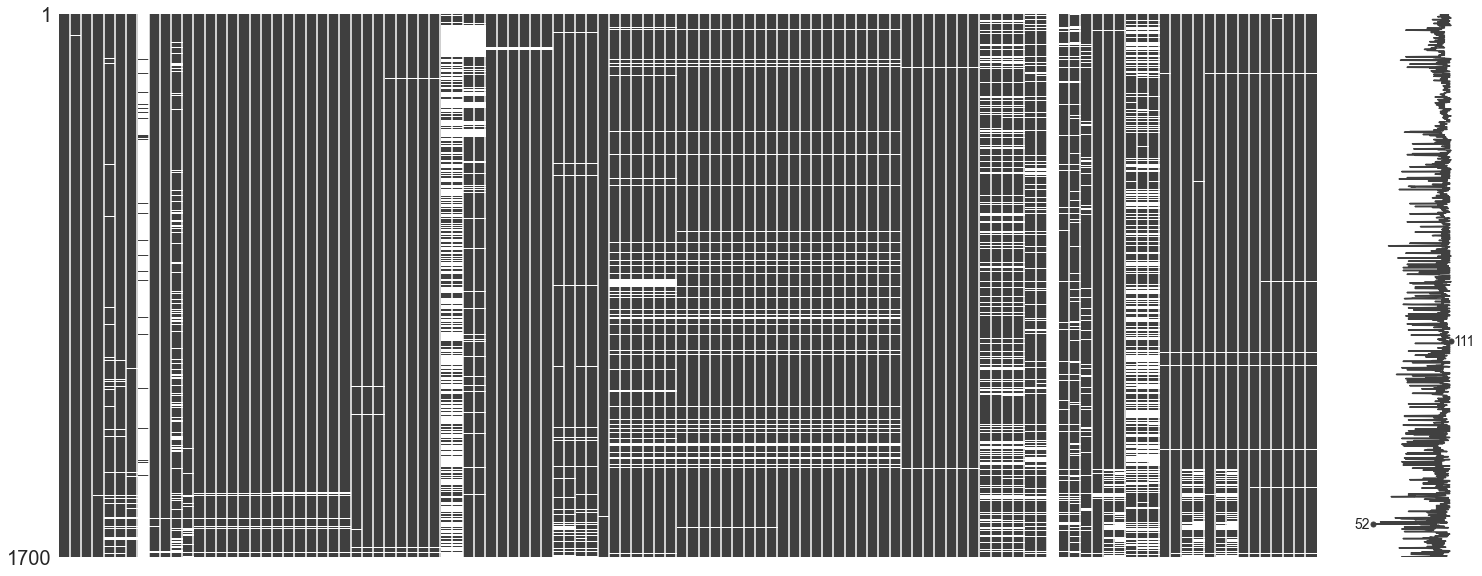

In [13]:
msno.matrix(X)

In [14]:
# Almost all features have some null values, will look at them in groups of columns that relate to each other.

# First will drop the 'ID' (don't need), 'IBS_NASL' (family history; only 72 non-null values), and
# 'KFK_BLOOD' (serum CPK; only 4 non-null values) columns

X = X.drop(['ID','IBS_NASL', 'KFK_BLOOD'], axis=1)

<AxesSubplot:>

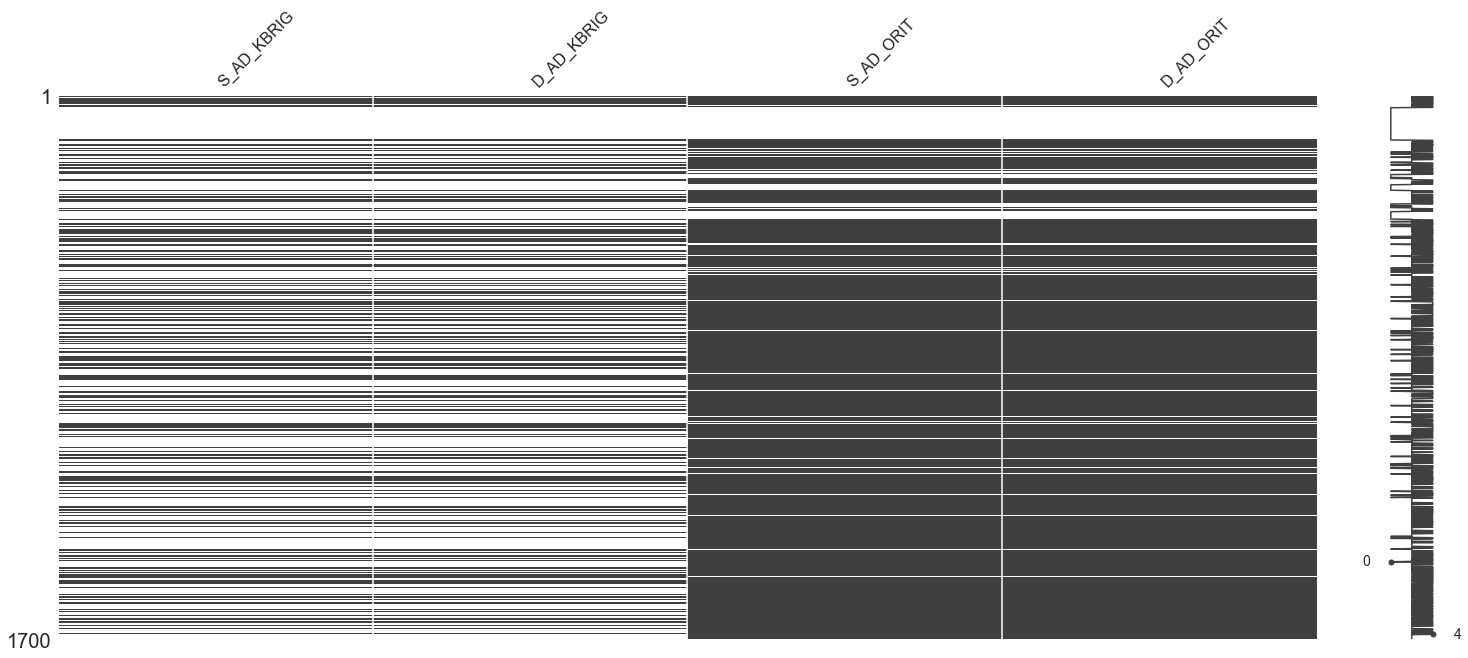

In [15]:
# There are two different place where blood pressure (S_ systolic and D_ diastolic) is taken-
# by the Emergency Cardiology team (_KBRIG) and by intensive care (_ORIT). The _KBRIG has 63% missing values

blood_pressure = ['S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT']
msno.matrix(mi[blood_pressure])

In [16]:
# How many rows are missing both sets of blood pressure data
X.loc[X[blood_pressure].isna().all(axis=1)].shape

(228, 109)

In [17]:
# How many rows are missing the ICU blood pressure data
X.loc[X[['S_AD_ORIT', 'D_AD_ORIT']].isna().all(axis=1)].shape

(267, 109)

In [18]:
# How do the statistics of the ICU blood pressure readings for patients without _KBRIG values compare 
# the statistics of the readings for the entire dataset?

# Statistics of ICU blood pressure for patients with null _KBRIG blood pressure
X[blood_pressure].loc[X[['S_AD_KBRIG', 'D_AD_KBRIG']].isna().all(axis=1)].describe()

,S_AD_KBRIG,D_AD_KBRIG,S_AD_ORIT,D_AD_ORIT
count,0.0,0.0,848.000000,848.000000
mean,NaN,NaN,134.846698,83.048349
std,NaN,NaN,30.250432,17.525324
min,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,120.000000,80.000000
50%,NaN,NaN,130.000000,80.000000
75%,NaN,NaN,150.000000,90.000000
max,NaN,NaN,260.000000,190.000000


In [19]:
# Overall statistics of blood pressure features
X[blood_pressure].describe()

,S_AD_KBRIG,D_AD_KBRIG,S_AD_ORIT,D_AD_ORIT
count,624.000000,624.000000,1433.000000,1433.000000
mean,136.907051,81.394231,134.588276,82.749477
std,34.997835,19.745045,31.348388,18.321063
min,0.000000,0.000000,0.000000,0.000000
25%,120.000000,70.000000,120.000000,80.000000
50%,140.000000,80.000000,130.000000,80.000000
75%,160.000000,90.000000,150.000000,90.000000
max,260.000000,190.000000,260.000000,190.000000


ICU blood pressure statistics of patients without the initial blood pressure data is pretty similar to the ICU blood pressure statistics of all patients. The Systolic blood pressure of patients taken by the Emergency Cardiac Team (ECT) is slightly higher than for patients in the ICU. 

There are only 624 patients who had blood pressure taken by the ECT, perhaps this is because these patients were having a less severe MI and were not rushed into surgery or other treatments. Will convert this into an indicator column to record whether the ECT recorded patient blood pressure. 

In [20]:
# Create indicator column and view it
X['AD_KBRIG'] = np.where(X['D_AD_KBRIG'].isna(), 0, 1)
bp = ['AD_KBRIG', 'S_AD_KBRIG', 'D_AD_KBRIG' ]
X[bp]

,AD_KBRIG,S_AD_KBRIG,D_AD_KBRIG
0,0,NaN,NaN
1,0,NaN,NaN
2,1,150.0,100.0
3,0,NaN,NaN
4,1,190.0,100.0
...,...,...,...
1695,0,NaN,NaN
1696,0,NaN,NaN
1697,0,NaN,NaN
1698,0,NaN,NaN


In [21]:
# Drop the _KBRIG features with null values
X = X.drop(['S_AD_KBRIG', 'D_AD_KBRIG'], axis=1)

In [22]:
X.describe()

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,FIB_G_POST,ant_im,lat_im,inf_im,post_im,IM_PG_P,ritm_ecg_p_01,ritm_ecg_p_02,ritm_ecg_p_04,ritm_ecg_p_06,ritm_ecg_p_07,...,n_r_ecg_p_09,n_r_ecg_p_10,n_p_ecg_p_01,n_p_ecg_p_03,n_p_ecg_p_04,n_p_ecg_p_05,n_p_ecg_p_06,n_p_ecg_p_07,n_p_ecg_p_08,n_p_ecg_p_09,n_p_ecg_p_10,n_p_ecg_p_11,n_p_ecg_p_12,fibr_ter_01,fibr_ter_02,fibr_ter_03,fibr_ter_05,fibr_ter_06,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NA_KB,NOT_NA_KB,LID_KB,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,AD_KBRIG
count,1692.000000,1700.000000,1696.000000,1594.000000,1627.000000,1649.000000,1691.000000,1692.000000,1452.000000,1646.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1689.000000,1690.000000,1690.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1433.000000,1433.000000,1688.000000,1685.000000,1686.000000,1688.000000,1688.000000,1688.000000,1617.000000,1620.000000,1620.000000,1628.000000,1699.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,...,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1331.000000,1329.000000,1325.000000,1325.000000,1416.000000,1415.000000,1575.000000,1497.000000,1574.000000,1684.000000,1592.000000,1572.000000,1043.000000,1014.000000,1023.000000,1691.000000,1695.000000,1592.000000,1569.000000,1690.000000,1590.000000,1569.000000,1690.000000,1689.000000,1687.000000,1683.000000,1683.000000,1684.000000,1684.000000,1700.000000
mean,61.856974,0.626471,0.554835,2.316186,1.205286,1.160703,1.393258,0.033688,3.340220,0.194411,0.025015,0.002382,0.011316,0.020846,0.017272,0.000596,0.002382,0.001189,0.001784,0.006540,0.000595,0.003567,0.001189,0.001784,0.134991,0.024852,0.007692,0.079149,0.071471,0.021855,0.005316,0.012995,134.588276,82.749477,0.065166,0.027300,0.067616,0.004739,0.004739,0.008886,1.570810,0.861728,1.014815,0.259214,0.029429,0.664729,0.061370,0.014858,0.000646,0.228036,...,0.001262,0.001262,0.001262,0.020189,0.003155,0.001262,0.017035,0.064353,0.004416,0.006309,0.021451,0.017666,0.049211,0.007692,0.009467,0.040237,0.002367,0.005325,0.003550,0.001183,0.401202,4.191422,0.022642,136.550943,0.481455,0.263717,8.782914,13.444890,4.684244,0.315914,0.140704,0.077608,0.592522,0.691321,0.387097,0.115316,0.484956,0.094221,0.058636,0.331953,0.113208,0.084767,0.283432,0.127294,0.666864,0.714795,0.743910,0.017815,0.202494,0.367059
std,11.259936,0.483883,0.836801,2.440586,1.040814,0.801400,1.088803,0.180478,3.098646,0.658722,0.156217,0.048766,0.105806,0.142910,0.130323,0.024405,0.048766,0.034473,0.042207,0.080628,0.024383,0.059637,0.034473,0.042207,0.341815,0.155720,0.087394,0.270052,0.257686,0.146252,0.072738,0.113285,31.348388,18.321063,0.246891,0.163004,0.251160,0.068700,0.068700,0.093875,1.711952,0.883249,1.404934,0.698850,0.169056,0.472238,0.240084,0.121023,0.025416,0.419702,...,0.035511,0.035511,0.035511,0.140692,0.056095,0.035511,0.129441,0.245459,0.066330,0.079204,0.144928,0.131774,0.216377,0.087394,0.096868,0.196572,0.048607,0.072803,0.059496,0.034391,0.490326,0.754076,0.148814,6.512120,0.387261,0.201802,3.400557,11.296316,2.871044,0.633738,0.424340,0.313632,0.491601,0.462176,0.487324,0.319498,0.779522,0.356203,0.275030,0.628311,0.399514,0.355107,0.450798,0.333401,0.471474,0.451646,0.436602,0.132317,0.401978,0.482145
min,26.00

The rest of the features have small numbers of null values. There are a large number of binary features, there are also some ordinal and continuous features. Due to the large number of features, I will group them by type to further investigate them. 

### Binary columns

First, I checked the value counts and number of null values for each column.

In [23]:
# Make list of binary feature column names
binary_columns = [x for x in X.columns if ((X[x].min()==0) & (X[x].max()==1))]

In [24]:
# How sparse is the data? Look at distributions of all binary features and
# Create a list of binary features that have fewer than 5% '1's

# Set counter to find number of binary columns
count = 0
# List to contain sparse feature names
sparse_cols = []
# Loop through binary columns, add sparse columns to sparse_cols list

for col in binary_columns:
    if X[col].value_counts(normalize=True)[0] > 0.95:
        sparse_cols.append(col)
    count += 1
    # Print distribution of all binary features
    print(f'{col}:')
    print(X[col].value_counts(normalize=True))
    print(f'Null values: {X[col].isna().sum()}')
    print(f'--------')
print(count)

SEX:
1    0.626471
0    0.373529
Name: SEX, dtype: float64
Null values: 0
--------
SIM_GIPERT:
0.0    0.966312
1.0    0.033688
Name: SIM_GIPERT, dtype: float64
Null values: 8
--------
nr_11:
0.0    0.974985
1.0    0.025015
Name: nr_11, dtype: float64
Null values: 21
--------
nr_01:
0.0    0.997618
1.0    0.002382
Name: nr_01, dtype: float64
Null values: 21
--------
nr_02:
0.0    0.988684
1.0    0.011316
Name: nr_02, dtype: float64
Null values: 21
--------
nr_03:
0.0    0.979154
1.0    0.020846
Name: nr_03, dtype: float64
Null values: 21
--------
nr_04:
0.0    0.982728
1.0    0.017272
Name: nr_04, dtype: float64
Null values: 21
--------
nr_07:
0.0    0.999404
1.0    0.000596
Name: nr_07, dtype: float64
Null values: 21
--------
nr_08:
0.0    0.997618
1.0    0.002382
Name: nr_08, dtype: float64
Null values: 21
--------
np_01:
0.0    0.998811
1.0    0.001189
Name: np_01, dtype: float64
Null values: 18
--------
np_04:
0.0    0.998216
1.0    0.001784
Name: np_04, dtype: float64
Null values: 

Many of the sparse columns are in a group of features with similar names. These features include ecg results, endocrine disease history, history of lung issues. I will combine these related sparse features into single columns that are a sum of the features. These similarly named features are always grouped together in the list of names- I will use this to create a loop to create these new columns. 

In [25]:
# Random name to start 'last_col'
last_col = 'aaa'
# Loop through sparse column names list
for col in sparse_cols:
    # Check to see if first 3 digits of column name matches the previous column
    if col[:3] == last_col[:3]:
        # Check to see if a column named the first 3 digits of the column name has been created
        if col[:3] in X.columns:
            # if the name exists, add this column to that column's total
            X[col[:3]] += X[col]
        # If the column hasn't been created yet, create it as the sum of this column of the last column
        else:
            X[col[:3]] = X[col] + X[last_col]
    # Change the last_col to the this column for the next iteration
    last_col = col

In [26]:
# One set of similar features has similar endings, manually make this new feature here
X['POST'] = X['K_SH_POST'] + X['SVT_POST'] + X['GT_POST'] + X['FIB_G_POST']
X['POST'].value_counts(normalize=True)

0.0    0.958457
1.0    0.037982
2.0    0.003561
Name: POST, dtype: float64

In [27]:
# Re-create the binary column list to include new columns
binary_columns = [x for x in X.columns if ((X[x].min()==0) & (X[x].max()==1))]

In [28]:
# Sparse columns won't contribute much to model success- drop them
# Create list of binary columns with less than 5% '1's
to_drop = []
for col in binary_columns:
    if X[col].value_counts(normalize=True)[0] > 0.95:
        to_drop.append(col)
        
# Drop sparse columns        
X = X.drop(to_drop, axis=1)

In [29]:
# Re-create binary column list to eliminate dropped columns
binary_columns = [x for x in X.columns if ((X[x].min()==0) & (X[x].max()==1))]
X.head()

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,endocr_01,zab_leg_01,zab_leg_02,S_AD_ORIT,D_AD_ORIT,O_L_POST,MP_TP_POST,ant_im,lat_im,inf_im,post_im,ritm_ecg_p_01,ritm_ecg_p_02,ritm_ecg_p_07,n_r_ecg_p_03,n_p_ecg_p_07,GIPO_K,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NA_KB,NOT_NA_KB,LID_KB,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TRENT_S_n,AD_KBRIG,nr_,n_r,n_p,fib,POST
0,77.0,1,2.0,1.0,1.0,2.0,3.0,7.0,0.0,0.0,0.0,0.0,180.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.7,138.0,NaN,NaN,8.0,16.0,4.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0.0,1.0,1.0,0.0,0.0
1,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,90.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.5,132.0,0.38,0.18,7.8,3.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0,0.0,1.0,0.0,0.0,0.0
2,52.0,1,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,180.0,100.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,132.0,0.30,0.11,10.8,NaN,3.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,68.0,0,0.0,0.0,0.0,2.0,2.0,3.0,1.0,0.0,1.0,0.0,120.0,70.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.9,146.0,0.75,0.37,NaN,NaN,2.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,60.0,1,0.0,0.0,0.0,2.0,3.0,7.0,0.0,0.0,0.0,0.0,160.0,90.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.5,132.0,0.45,0.22,8.3,NaN,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0


The majority of binary features are mostly zeros with some ones and small number of null values. In preprocessing, I will replace the null values with zero or use the IterativeImputer to determine the appropriate replacement value.

##### To consider again later
The series of features that starts with 'n_pr_ecg_p_' are ECG findings at the time of admission and have the same 115 rows with null values. Similarly, features starting with 'ritm_ecg_p' have the same 152 rows containing null values.

'GIPO_K' & 'GIPER_NA' have high number of nulls and refer to missing blood work. 'NA_KB', 'NOT_NA_KB' & 'LID_KB' also have many nulls  and refer to medicines given by the Emergency Cardiac Team (it seems like the team would not neglect to mention giving a drug, so the zero for null is probably safe here). 

### Ordinal and Numeric Columns

Next I look at the ordinal and numeric columns to determine how they should be processed.

In [30]:
# First capture the column names into lists by type
ordinal_columns = [x for x in X.columns if ((X[x].min()==0) & (X[x].max()>1) & (X[x].max()<9))]
numeric_columns = [x for x in X.columns if (X[x].min()>0) | (X[x].max()>9)]

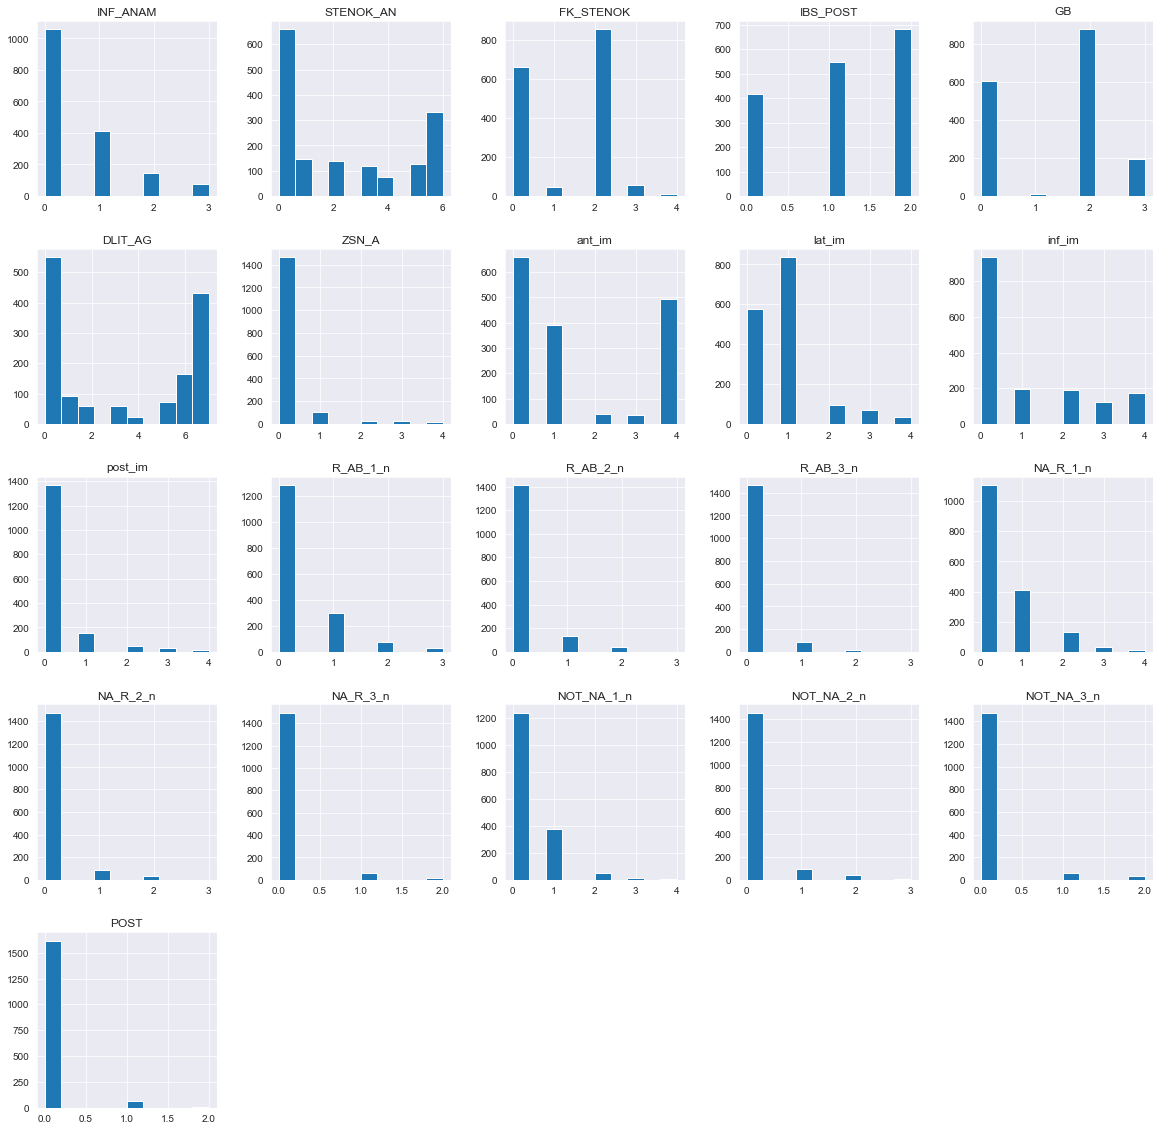

In [31]:
# Look at distribution of ordinal columns
X[ordinal_columns].hist(figsize=(20, 20))
plt.show()

Values don't have a distribution pattern. Many are have a lot of zeros. For null values, zero seems like a safe bet again- if they didn't record this information it likely didn't happen.

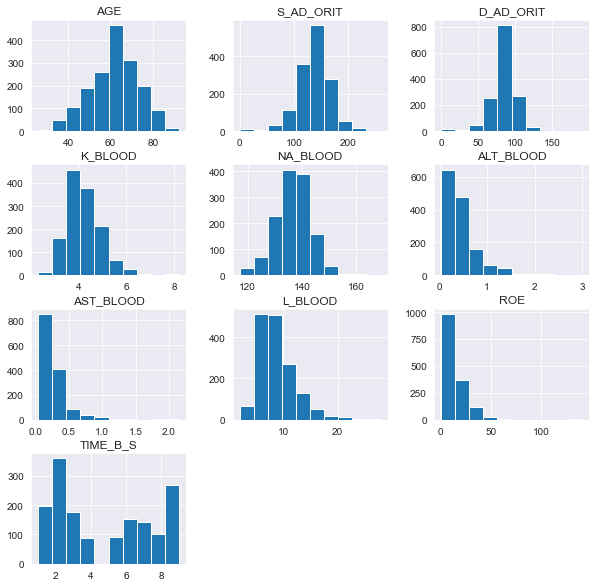

In [32]:
# Look at distribution of numberic columns
X[numeric_columns].hist(figsize=(10, 10))
plt.show()

Many have a fairly normal distribution.

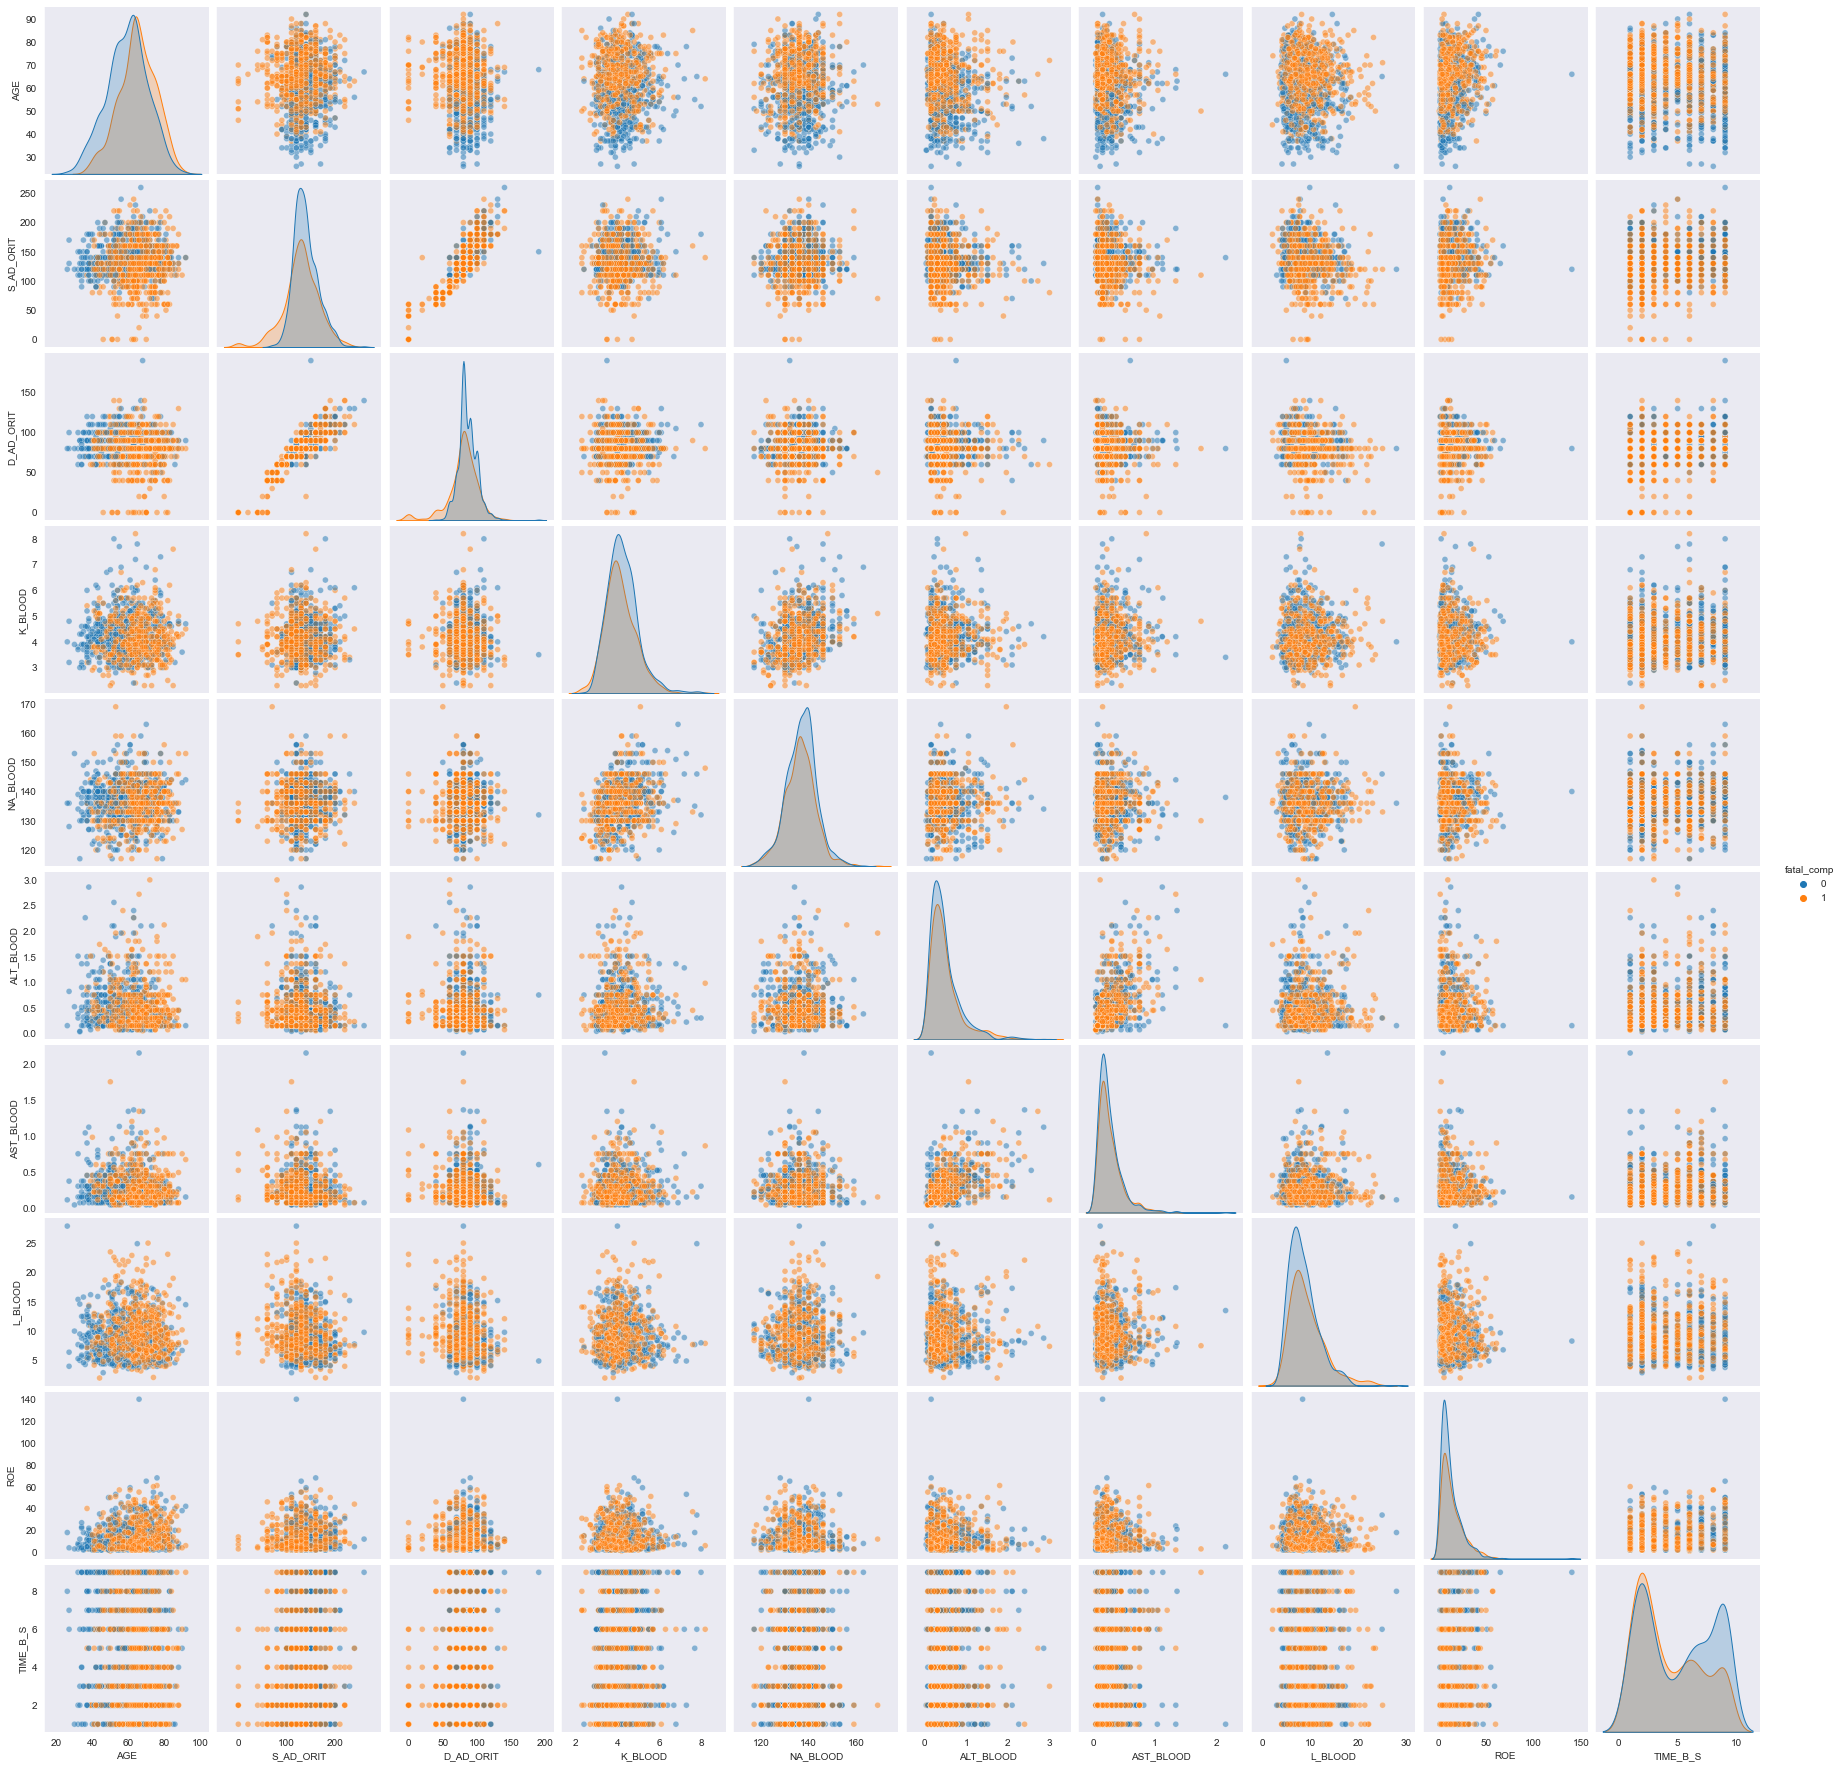

In [33]:
# Look at relationships between numeric columns and the target column
pair_plot = numeric_columns+ ['fatal_comp']
sns.pairplot(mi[pair_plot], hue='fatal_comp', plot_kws={'alpha':0.5})

With the exception of systolic and diastolic blood pressure, there aren't many relationships between the columns. As far as hue- there don't seem to be any clear patterns.

In [34]:
# To determine the best method to impute null values in the numeric columns,
# I look at the mean, median and mode for each feature

for col in numeric_columns:
    print(f'{col}: mean {X[col].mean(): .2f}, median {X[col].median()}, mode {X[col].mode()}')

AGE: mean  61.86, median 63.0, mode 0    63.0
dtype: float64
S_AD_ORIT: mean  134.59, median 130.0, mode 0    130.0
dtype: float64
D_AD_ORIT: mean  82.75, median 80.0, mode 0    80.0
dtype: float64
K_BLOOD: mean  4.19, median 4.1, mode 0    4.0
dtype: float64
NA_BLOOD: mean  136.55, median 136.0, mode 0    136.0
dtype: float64
ALT_BLOOD: mean  0.48, median 0.38, mode 0    0.15
dtype: float64
AST_BLOOD: mean  0.26, median 0.22, mode 0    0.15
dtype: float64
L_BLOOD: mean  8.78, median 8.0, mode 0    6.9
dtype: float64
ROE: mean  13.44, median 10.0, mode 0    5.0
dtype: float64
TIME_B_S: mean  4.68, median 4.0, mode 0    2.0
dtype: float64


For the normally distributed features the median and mode are the same or close to it. For the others the mode seems like the most representative choice. So, will choose 'most frequent' to impute null values for the numeric columns. 

### Correlations

In [35]:
corrMatrix = X.corr().abs()


s = corrMatrix.unstack()
so = pd.DataFrame(s.sort_values())



In [36]:
so.loc[(so[0] < 1) & (so[0]>=0.75)]

,,0
FK_STENOK,STENOK_AN,0.763019
STENOK_AN,FK_STENOK,0.763019
ritm_ecg_p_07,ritm_ecg_p_01,0.765292
ritm_ecg_p_01,ritm_ecg_p_07,0.765292
DLIT_AG,GB,0.775865
GB,DLIT_AG,0.775865
ritm_ecg_p_02,MP_TP_POST,0.845695
MP_TP_POST,ritm_ecg_p_02,0.845695
D_AD_ORIT,S_AD_ORIT,0.861266
S_AD_ORIT,D_AD_ORIT,0.861266


In [37]:
# Drop correlated features that have less missing data or fewer zeros for binary/ordinal features
to_drop = ['STENOK_AN','ritm_ecg_p_07', 'DLIT_AG', 'ritm_ecg_p_02']
X = X.drop(to_drop, axis=1)

In [38]:
ordinal_columns = [x for x in X.columns if ((X[x].min()==0) & (X[x].max()>1) & (X[x].max()<15))]
numeric_columns = [x for x in X.columns if (X[x].min()>0) | (X[x].max()>15)]
binary_columns = [x for x in X.columns if ((X[x].min()==0) & (X[x].max()==1))]

## Data Modeling

One of the goals of this project is to develop a model that will allow cardiologists to predict which patients are likely to have serious complications in the first year after MI. I will first try several different types of classifiers to see which gives the best initial model.

In [39]:
%%script echo skipping
def evaluate(estimator, X_train, X_test, y_train, y_test, use_decision_function='yes'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    use_decision_function allows you to toggle whether you use decision_function or
    predict_proba in order to get the output needed for roc_auc_score
    If use_decision_function == 'skip', then it ignores calculating the roc_auc_score
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # output needed for roc_auc_score
    if use_decision_function == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif use_decision_function == 'yes': # not all classifiers have decision_function
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif use_decision_function == 'no':
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception ("The value for use_decision_function should be 'skip', 'yes' or 'no'.")

    print(type(test_out))
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds): .4f}")
    print(f"F1 Score: {f1_score(y_train, train_preds): .4f}")
    print(f"Recall Score: {recall_score(y_train, train_preds): .4f}")
    if type(train_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out): .4f}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds): .4f}")
    print(f"F1 Score: {f1_score(y_test, test_preds): .4f}")
    print(f"Recall Score: {recall_score(y_test, test_preds): .4f}")
    if type(test_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out): .4f}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format=".3g")
    plt.show()
print('ehllo')

skipping


In [40]:
# Separate data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

There are two imputers that I would like to try, so putting them into pipelines. 

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy:  0.7390
F1 Score:  0.6921
Recall Score:  0.6446
ROC-AUC:  0.8096
--------------------
Test Scores
-----------
Accuracy:  0.7059
F1 Score:  0.6552
Recall Score:  0.5901
ROC-AUC:  0.7837


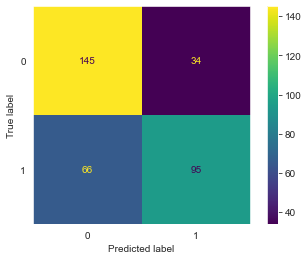

In [41]:
# Preprocessor 1 - use the SimpleImputere to fill null values by methods determined in the 
# data processing section above.

# fill nulls in binary and ordinal columns with zero
binary_si = SimpleImputer(strategy="constant", fill_value=0)
ordinal_si = SimpleImputer(strategy="constant", fill_value=0)
# fill null in numeric columns with mode/most_frequent
numeric_si = SimpleImputer(strategy="most_frequent")

# Numeric features had mostly normal distributions, so use StandardScaler
# to scale them
numeric_transformer = Pipeline(steps=[
    ('numeric_si', numeric_si),
    ('scaler', StandardScaler())])

# Ordinal features were not normally distributed, use MinMaxScaler
ordinal_transformer = Pipeline(steps=[
    ('ordinal_si', ordinal_si),
    ('scaler', MinMaxScaler())])

# Put it all together into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('bin', binary_si, binary_columns),
        ('ord', ordinal_transformer, ordinal_columns)])

# Add preprocessor and classifier to pipeline
clf_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=400))])


# Fit and evaluate pipeline
clf_lr.fit(X_train, y_train)
ut.evaluate(clf_lr, X_train, X_test, y_train, y_test)

My focus for this model is the recall score because I would like to minimize the number of patients that we miss flagging as having potentially fatal complications. I am okay with some false positives, though if that number gets too high the model becomes less useful. 

Model clf_lr (p1, lr) has a recall score of 0.59 on the test data.

In [42]:
# Create a dataframe to track model results
data =[[1, 'lr', 0.6921, 0.6552, 0.6446, 0.5901]]

results = pd.DataFrame(data, columns = ['preprocessor', 'classifier', 'f1_train', 'f1_test','recall_train', 'recall_test'])
results

,preprocessor,classifier,f1_train,f1_test,recall_train,recall_test
0,1,lr,0.6921,0.6552,0.6446,0.5901


<class 'numpy.ndarray'>
Train Scores
------------
Accuracy:  0.7324
F1 Score:  0.6846
Recall Score:  0.6381
ROC-AUC:  0.8073
--------------------
Test Scores
-----------
Accuracy:  0.7118
F1 Score:  0.6644
Recall Score:  0.6025
ROC-AUC:  0.7945


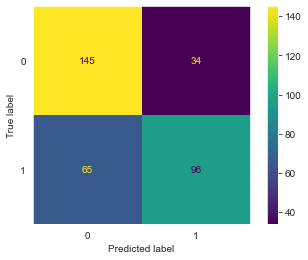

In [43]:
# This time I will try using the IterativeImputer to decide how to fill the null values

# Instanciate the imputer
imputer = IterativeImputer(sample_posterior=True, n_nearest_features=4, initial_strategy='median', random_state=5)

# Create the numeric and ordinal transformers at before but with the IterativeImputer
numeric_transformer2 = Pipeline(steps=[
    ('imputer', imputer),
    ('scaler', StandardScaler())])

ordinal_transformer2 = Pipeline(steps=[
    ('imputer', imputer),
    ('scaler', MinMaxScaler())])

# Create preprocessor 2 using IterativeImputer
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer2, numeric_columns),
        ('bin', imputer, binary_columns),
        ('ord', ordinal_transformer2, ordinal_columns)])

# Put preprocessor 2 in pipeline with the Logistic Regression classifier
clf_lr2 = Pipeline(steps=[('preprocessor', preprocessor2),
                          ('classifier', LogisticRegression(max_iter=400))])

# Fit and evaluate the pipeline
clf_lr2.fit(X_train, y_train)
ut.evaluate(clf_lr2, X_train, X_test, y_train, y_test)

In [44]:
# Add results to dataframe
results.loc[len(results.index)] = [2, 'lr', 0.6846, 0.6644, 0.6381, 0.6025]
results

,preprocessor,classifier,f1_train,f1_test,recall_train,recall_test
0,1,lr,0.6921,0.6552,0.6446,0.5901
1,2,lr,0.6846,0.6644,0.6381,0.6025


The different preprocessing methods for linnear regression models didn't make a huge difference, with the simple imputer giving better training results and the iterative imputer giving better test results.

In [45]:
%%script echo skipping
preprocessors = [preprocessor, preproceessor2]
classifiers = [LinearSVC(), GaussianNB(), XGBClassifier()]


params = [{'preprocessor': preprocessors, 'classifier': classifiers}, 
        {'preprocessor': preprocessors, 'classifier': [LogisticRegression()], 'classifier__max_iter': [1000]}]



gsearch = GridSearchCV(lr, params, cv=5, scoring='recall')
gsearch.fit(X_train, y_train)

print(f'Best model: {gsearch.best_score_} using {gsearch.best_params_}')
ut.evaluate(gsearch, X_train, X_test, y_train, y_test, use_decision_function='skip')

skipping


/Users/cindyreiner/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'>
Train Scores
------------
Accuracy:  0.7338
F1 Score:  0.6841
Recall Score:  0.6333
ROC-AUC:  0.8106
--------------------
Test Scores
-----------
Accuracy:  0.7029
F1 Score:  0.6529
Recall Score:  0.5901
ROC-AUC:  0.7857


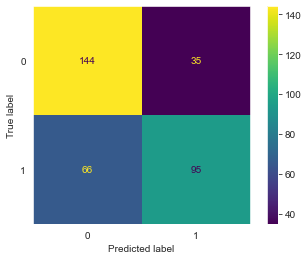

In [46]:
# My data is sparse, so will try LinnearSVC which works well with sparse data
clf_svc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearSVC())])
clf_svc.fit(X_train, y_train)
ut.evaluate(clf_svc, X_train, X_test, y_train, y_test)

In [47]:
# Add results to dataframe
results.loc[len(results.index)] = [1, 'svc', 0.6841, 0.6507, 0.6333, 0.5901]
results

,preprocessor,classifier,f1_train,f1_test,recall_train,recall_test
0,1,lr,0.6921,0.6552,0.6446,0.5901
1,2,lr,0.6846,0.6644,0.6381,0.6025
2,1,svc,0.6841,0.6507,0.6333,0.5901


This model did not preform as well as the logistic regression models when looking at recall scores of training and test data.

/Users/cindyreiner/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'>
Train Scores
------------
Accuracy:  0.7331
F1 Score:  0.6841
Recall Score:  0.6349
ROC-AUC:  0.8088
--------------------
Test Scores
-----------
Accuracy:  0.7029
F1 Score:  0.6553
Recall Score:  0.5963
ROC-AUC:  0.7962


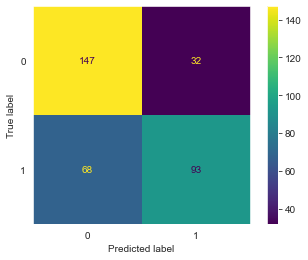

In [48]:
# Not hopeful, but will try preprocessor 2 with the linearSVC classifier
clf_svc2 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('classifier', LinearSVC(max_iter=1000))])
clf_svc2.fit(X_train, y_train)
ut.evaluate(clf_svc2, X_train, X_test, y_train, y_test)

In [49]:
# Add results to dataframe
results.loc[len(results.index)] = [2, 'svc', 0.6812, 0.6507, 0.6333, 0.5901]
results

,preprocessor,classifier,f1_train,f1_test,recall_train,recall_test
0,1,lr,0.6921,0.6552,0.6446,0.5901
1,2,lr,0.6846,0.6644,0.6381,0.6025
2,1,svc,0.6841,0.6507,0.6333,0.5901
3,2,svc,0.6812,0.6507,0.6333,0.5901


Nearly the same recall results as the preprocessor 1. 

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy:  0.6978
F1 Score:  0.6334
Recall Score:  0.5735
ROC-AUC:  0.7782
--------------------
Test Scores
-----------
Accuracy:  0.6794
F1 Score:  0.6148
Recall Score:  0.5404
ROC-AUC:  0.7706


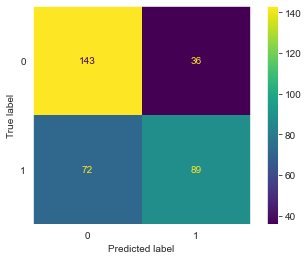

In [50]:
# The GaussianNB classifier is also supposed to work well with sparse data
clf_gnb = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('classifier', GaussianNB())])
clf_gnb.fit(X_train, y_train)
ut.evaluate(clf_gnb, X_train, X_test, y_train, y_test, use_decision_function='no')

In [51]:
# Add results to dataframe
results.loc[len(results.index)] = [2, 'gnb', 0.6334, 0.6148, 0.5735, 0.5404]
results

,preprocessor,classifier,f1_train,f1_test,recall_train,recall_test
0,1,lr,0.6921,0.6552,0.6446,0.5901
1,2,lr,0.6846,0.6644,0.6381,0.6025
2,1,svc,0.6841,0.6507,0.6333,0.5901
3,2,svc,0.6812,0.6507,0.6333,0.5901
4,2,gnb,0.6334,0.6148,0.5735,0.5404


There was no improvement in scores with the gaussian naive bayes classifier.

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy:  0.8360
F1 Score:  0.8049
Recall Score:  0.7431
ROC-AUC:  0.9136
--------------------
Test Scores
-----------
Accuracy:  0.7147
F1 Score:  0.6840
Recall Score:  0.6522
ROC-AUC:  0.7915


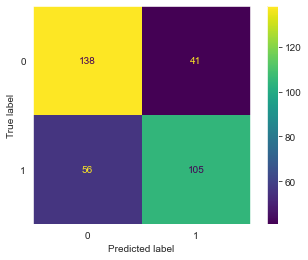

In [52]:
# Finally, I will try the XGBoost Classifier
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])
clf_xgb.fit(X_train, y_train)
ut.evaluate(clf_xgb, X_train, X_test, y_train, y_test, use_decision_function='no')

In [53]:
# Add results to dataframe
results.loc[len(results.index)] = [1, 'xgb', 0.8049, 0.6840, 0.7431, 0.6522]
results

,preprocessor,classifier,f1_train,f1_test,recall_train,recall_test
0,1,lr,0.6921,0.6552,0.6446,0.5901
1,2,lr,0.6846,0.6644,0.6381,0.6025
2,1,svc,0.6841,0.6507,0.6333,0.5901
3,2,svc,0.6812,0.6507,0.6333,0.5901
4,2,gnb,0.6334,0.6148,0.5735,0.5404
5,1,xgb,0.8049,0.6840,0.7431,0.6522


This model was an improvement over the others tried so far.

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy:  0.8199
F1 Score:  0.7849
Recall Score:  0.7221
ROC-AUC:  0.8956
--------------------
Test Scores
-----------
Accuracy:  0.7206
F1 Score:  0.6780
Recall Score:  0.6211
ROC-AUC:  0.8148


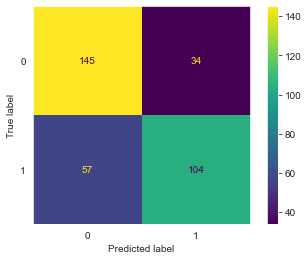

In [54]:
# And XGBClassifier with the second preprocessor
clf_xgb2 = Pipeline(steps=[('preprocessor', preprocessor2),
                       ('classifier', XGBClassifier())])
clf_xgb2.fit(X_train, y_train)
ut.evaluate(clf_xgb2, X_train, X_test, y_train, y_test, use_decision_function='no')

In [55]:
# Add results to dataframe
results.loc[len(results.index)] = [2, 'xgb', 0.7849, 0.6780, 0.7221, 0.6211]
results.sort_values(by='recall_test', ascending=False)

,preprocessor,classifier,f1_train,f1_test,recall_train,recall_test
5,1,xgb,0.8049,0.6840,0.7431,0.6522
6,2,xgb,0.7849,0.6780,0.7221,0.6211
1,2,lr,0.6846,0.6644,0.6381,0.6025
0,1,lr,0.6921,0.6552,0.6446,0.5901
2,1,svc,0.6841,0.6507,0.6333,0.5901
3,2,svc,0.6812,0.6507,0.6333,0.5901
4,2,gnb,0.6334,0.6148,0.5735,0.5404


 XGBClassifier with preprocessor 2 is more over fit as well as getting lower scores. 
 
Two best model types are logistic regression(clf_lr2) with preprocessor 2 and XGBClassifier(clf_xgb) with preprocessor1. Will continue forward with these two.

## Evaluate Initial Models

Before moving on to tuning the models, I will look at the features that are most important in driving these models.

In [57]:
%%script echo skipping
# First look at most important features for the LogisticRegression model

viz = FeatureImportances(clf_lr2[1], size=(900,900))
viz.fit(X, y)
viz.show()

skipping


The two most important features are if the patient received NSAIDs on the first and second day in the ICU, respectively. The third most important is receiving asprin in the ICU. Next are high sodium in blood test, whether they had blood pressure taken by the ECT, receiving trentol in the ICU, NSAIDs on 3rd day and a history of heart arrythmias, tachycardia, fibrillation or other heart irregularities. 

In [58]:
%%script echo skipping
viz = FeatureImportances(clf_xgb[1], size=(900,900))
viz.fit(X, y)
viz.show()

skipping


In this model, blood sodium level is the most important feature, followed by receiving NSAIDS on first and second day in the ICU. In this model both age and sex are among the more important features. Also important are receiving trental, receiving opiods on the 3rd day in ICU and experiencing atrial fibrillation at time of admission to ICU.

Next, I will look at features that are important in both of the models.

In [59]:
# First I create dictionaries of the features and their feature importances/coefficients
impts = dict(zip(X.columns, clf_xgb.steps[1][1].feature_importances_))
coefs = dict(zip(X.columns, list(clf_lr2.steps[1][1].coef_[0])))
# Create dataframe from the dictionaries
feat_impt = pd.DataFrame(list(coefs.items()),columns = ['features','LR_coefs']) 
feat_impt['XGB_impt'] = feat_impt['features'].map(impts)
feat_impt.head()

,features,LR_coefs,XGB_impt
0,AGE,0.334566,0.028776
1,SEX,-0.067466,0.040472
2,INF_ANAM,-0.225116,0.013929
3,FK_STENOK,-0.035593,0.011592
4,IBS_POST,0.030040,0.013907


In [60]:
# The feature importances and coefficients are on different scales and the 
# coefficients also have negative numbers making it difficult to compare directly

# Replace coefficients with their absolute value
feat_impt['LR_coefs'] = abs(feat_impt['LR_coefs'])

# Instanciate scaler and use on both numeric columns
scaler = MinMaxScaler()
feat_impt[['LR_coefs', 'XGB_impt']] = scaler.fit_transform(feat_impt[['LR_coefs', 'XGB_impt']])
feat_impt.head()

,features,LR_coefs,XGB_impt
0,AGE,0.136085,0.295393
1,SEX,0.024205,0.415453
2,INF_ANAM,0.090240,0.142989
3,FK_STENOK,0.010854,0.118998
4,IBS_POST,0.008529,0.142761


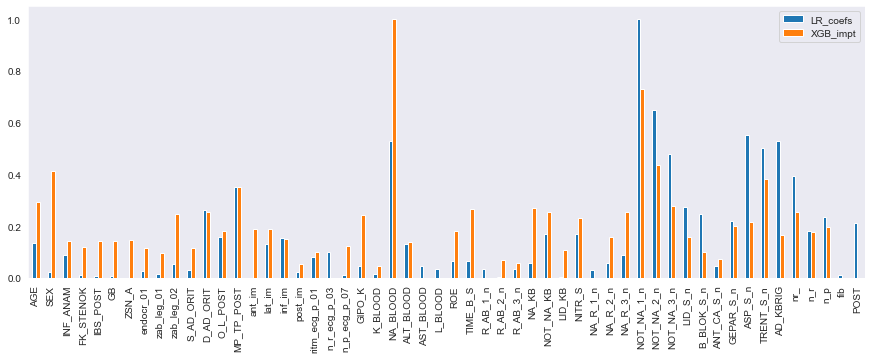

In [61]:
# Plot the coefficients/feature importances to see how they compare

feat_impt.plot(kind='bar', figsize=(15, 5))
plt.xticks(np.arange(54), feat_impt['features'],rotation=90)
plt.show()

In [62]:
# From the graph it looks like anything with a value of over 0.2 in
# both models would be important to both
feat_impt.loc[(feat_impt['LR_coefs'] >= 0.2) & (feat_impt['XGB_impt'] >= 0.2)]

,features,LR_coefs,XGB_impt
11,D_AD_ORIT,0.262336,0.255040
13,MP_TP_POST,0.352004,0.351454
23,NA_BLOOD,0.530679,1.000000
39,NOT_NA_1_n,1.000000,0.730740
40,NOT_NA_2_n,0.648856,0.435669
41,NOT_NA_3_n,0.477961,0.279663
45,GEPAR_S_n,0.220202,0.200377
46,ASP_S_n,0.554077,0.218862
47,TRENT_S_n,0.503188,0.382497
49,nr_,0.393367,0.256874


| Feature   | meaning  |
|  -------- |    :------:  |
| D_AD_ORIT | Diastolic BP in ICU  |
|MP_TP_POST | atrial fib at admission to ICU or pre-hospital  |
|NA_BLOOD   | Sodium in the blood  |
|NOT_NA_1_n | NSAIDS day 1 in ICU  |
|NOT_NA_2_n | NSAIDS day 2 in ICU  |
|NOT_NA_3_n | NSAIDS day 3 in ICU  |
|GEPAR_S_n  | use of anticoagulants in ICU  |
|ASP_S_n    | asprin in ICU  |
|TRENT_S_n  | trental in ICU  |
|nr_        | a combined feature of different sorts of cardiac irregularites in the anamnesis  |

## Tune Logistic Regression model

I will next try to tune the Logistic Regression model with the second preprocessing method. The score of the initial model on the test set were: f1 score- 0.6644, recall- 0.6025

In [63]:
%%script echo skipping
# Test different solvers, C values, max iterations & penalties in the Logistic Regression model 

# There are several solver possibilites that have different penalty options
# These solvers have only the default 'l2 penalty', other solvers and their
# penalties are laid out in the parameters grid
solvers = ['newton-cg','lbfgs'] 
c_values = [100, 10, 1.0, 0.1, 0.01] 
max_iter = [100, 400]

# define grid search
params = [{'classifier__solver':solvers,'classifier__C':c_values, 'classifier__max_iter':max_iter},
          {'classifier__solver':['liblinear'], 'classifier__penalty': ['l2', 'l1'],
               'classifier__C':c_values, 'classifier__max_iter':max_iter}, 
          {'classifier__solver':['saga'], 'classifier__penalty': ['l2', 'elasticnet', 'l1'],
               'classifier__C':c_values, 'classifier__max_iter':max_iter}]

clf_lr3 = Pipeline(steps=[('preprocessor', preprocessor2), ('classifier', LogisticRegression())])
gs_lr = GridSearchCV(clf_lr3, params, cv=5, scoring='recall', verbose=1) 
gs_lr.fit(X_train, y_train)
# summarize results
print(f'Best recall score: {gs_lr.best_score_} using {gs_lr.best_params_}') 
ut.evaluate(gs_lr, X_train, X_test, y_train, y_test, use_decision_function='yes')

skipping


<img src="images/firstLR.png" width=1600 />

Best f1 score: 0.6082, recall score: 0.6599 using C=0.01, max_iter=100, penalty='l1', solver = liblinear, which is better than the initial 0.6025 recall score. Will use the liblinear solver and l1 penalty to test a narrower range of C values and max iterations based around the best values from this gridsearch.

In [64]:
# C value and max iteration values to try
c_values = [0.05, 0.025, 0.01, 0.0075, 0.005]
max_iter = [70, 90, 100, 110, 130]

# define grid search
params = [{'classifier__C':c_values, 'classifier__max_iter':max_iter},]

lr = LogisticRegression(solver='liblinear', penalty='l1')

clf_lr4 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('classifier', lr)])

gs_lr2 = GridSearchCV(clf_lr4, params, cv=5, scoring='recall', verbose=5)
gs_lr2.fit(X_train, y_train)

# summarize results
print(f'Best recall score: {gs_lr2.best_score_} using {gs_lr2.best_params_}')
ut.evaluate(gs_lr2, X_train, X_test, y_train, y_test, use_decision_function='yes')

Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

Best f1 and recall scores unchanged from the first test. Best C value identified is the same, 0.01, best max iterations is lower at 70. Will put these values into a final LogisticRegression model.

In [ ]:
# Instanciate model with best parameters
lr2 = LogisticRegression(solver='liblinear', penalty='l1', C=0.01, max_iter=70)

# Create model pipeline
clf_lr5 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('classifier', lr2)])
# Fit model to training data
clf_lr5.fit(X_train, y_train)

# Summarize results
ut.evaluate(clf_lr5, X_train, X_test, y_train, y_test, use_decision_function='yes')

This model isn't great for predicting whether patients will have complications in the first year after MI. It misses about 1/3 of patient who do have complications and flags 1/2 of patients who don't have any. There isn't a lot to do with tuning this model- would either need to preprocess the data in a better way, get more types of data or conclude that this just isn't the right model for this problem. 

## Tune XGBoostClassifier model

The XGBClassifier with the first preprocessing method was the best of the initial models with an f1 score on test data of 0.7431, and a recall score of 0.6522. The XGBClassifier has a lot of parameters to tune. I will use a method that sets the learning rate high and the number of estimators low to start tuning.

In [ ]:
%%script echo skipping

# Parameters and values to test
maxdepth = [2, 3, 4]
minchildweight = [1, 3, 5]

# Create paramater grid
params = {'classifier__max_depth':maxdepth,'classifier__min_child_weight':minchildweight}

# Instanciate model
xgbc2 = XGBClassifier(n_estimators = 100, learning_rate = 1, objective = 'binary:logistic', random_seed=8)
# Create model pipeline
clf_xgb4 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgbc2)])

# Create gridsearch and fit models to the training data
gs_xgb4 = GridSearchCV(clf_xgb4, params, scoring='recall',verbose=1)
gs_xgb4.fit(X_train, y_train)

# Summarize results
print(f'Best recall score: {gs_xgb4.best_score_} using {gs_xgb4.best_params_}')
ut.evaluate(gs_xgb4, X_train, X_test, y_train, y_test, use_decision_function='no')

<img src="images/xgb_maxdepth.png" width=1600 />

This search identified best value for the max_depth as 2 and the min_child_weight as 5. The recall score improved slightly from 0.6522 to 0.6584, while the f1 score decreased from 0.7431 to 0.6667. The model is still pretty overfit. Will next try some regularization parameters that might help with overfitting. 

In [ ]:
%%script echo skipping
# Parameters and values to test
gamma= [0, 0.1, 0.25, 0.5]
colsample_bytree = [0.5, 0.7, 0.9, 1]
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
reg_lambda = [1, 1.5, 2, 4]

# Create parameter grid
params = {'classifier__gamma':gamma, 'classifier__colsample_bytree':colsample_bytree, 
          'classifier__reg_alpha':reg_alpha, 'classifier__reg_lambda':reg_lambda}

# Instanciate classifier
xgbc3 = XGBClassifier(n_estimators = 100, learning_rate = 1, objective = 'binary:logistic', 
                      max_depth = 2, min_child_weight = 5, random_seed=8)
# Create model pipeline
clf_xgb5 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgbc3)])

# Gridsearch and fit the models to the training data
gs_xgb5 = GridSearchCV(clf_xgb5, params, scoring='recall',verbose=1)
gs_xgb5.fit(X_train, y_train)

# Summarize results
print(f'Best recall score: {gs_xgb5.best_score_} using {gs_xgb5.best_params_}')
ut.evaluate(gs_xgb5, X_train, X_test, y_train, y_test, use_decision_function='no')

<img src="images/xgb_colsample.png" width=1600 />

The f1 and recalls did not change much in this model, but it is a bit less over fit. Will next tune the number of estimators and learning rate. 

In [ ]:
%%script echo skipping
# Parameter values to test
n_estimators = [100, 400, 800, 1600]
learning_rate = [0.01, 0.1]

# Create parameter grid
params = {'classifier__n_estimators':n_estimators, 'classifier__learning_rate':learning_rate}

# Instanciate classifier
xgbc4 = XGBClassifier(objective = 'binary:logistic', max_depth = 2, min_child_weight = 5, 
                      gamma= 0, reg_alpha = 1, colsample_bytree = 0.5, reg_lambda = 1.5, 
                      random_seed=8)
# Create model pipeline
clf_xgb6 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgbc4)])

# Gridsearch and fit models to training data
gs_xgb6 = GridSearchCV(clf_xgb6, params, scoring='recall',verbose=1)
gs_xgb6.fit(X_train, y_train)

# Summarize results
print(f'Best recall score: {gs_xgb6.best_score_} using {gs_xgb6.best_params_}')
ut.evaluate(gs_xgb6, X_train, X_test, y_train, y_test, use_decision_function='no')

<img src="images/xgb_learningrate.png" width=1600 />

Decreasing the learning rate to 0.1 and increasing iterations to 1600 had a positive effect on the f1 and recall scores going from 0.6688 & 0.6584, respectively to 0.6794 & 0.6646. So the model is getting slightly better, but the tuning is not having drastic results. 

In [ ]:
# Final tuning of parameters around the previously found best values
maxdepth = [2, 3, 4]
minchildweight = [3, 5, 7]
gamma= [0, 0.1, 0.5]
colsample_bytree = [0.5, 0.75,  1]

# Create parameter grid
params = {'classifier__max_depth':maxdepth, 'classifier__min_child_weight':minchildweight,
          'classifier__gamma':gamma, 'classifier__colsample_bytree':colsample_bytree}

# Instanciate classifier
xgbc3 = XGBClassifier(n_estimators = 1600, learning_rate = 0.1, reg_alpha = 1, 
                      reg_lambda = 1.5, objective = 'binary:logistic', random_seed=8)

# Create model pipeline
clf_xgb5 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgbc3)])

# Gridsearch and fit models
gs_xgb5 = GridSearchCV(clf_xgb5, params, scoring='recall',verbose=5)
gs_xgb5.fit(X_train, y_train)

# Summarize results
print(f'Best recall score: {gs_xgb5.best_score_} using {gs_xgb5.best_params_}')
ut.evaluate(gs_xgb5, X_train, X_test, y_train, y_test, use_decision_function='no')

In [ ]:
# Run the model with the final values for the tuned parameters to use for analysis

# Instanciate the classifier
xgbc6 = XGBClassifier(n_estimators= 1600, learning_rate=0.1, objective = 'binary:logistic', 
                      max_depth = 2, min_child_weight = 5, gamma= 0, reg_alpha = 1, 
                      colsample_bytree = 0.5, reg_lambda = 1.5, random_seed=8)
# Create the model pipeline
clf_xgb8 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgbc6)])

# Fit the model on training data
clf_xgb8.fit(X_train, y_train)

# Summarize results
ut.evaluate(clf_xgb8, X_train, X_test, y_train, y_test, use_decision_function='no')

## Evaluation

I next want to evaluate the important features from the two best models from the tuning attempts, clf_lr5 for Logistic Regression and clf_xgb8 for XGBClassifier. 

In [ ]:
# First I create dictionaries of the features and feature importances/coefficients
impts2 = dict(zip(X.columns, clf_xgb8.steps[1][1].feature_importances_))
coefs2 = dict(zip(X.columns, list(clf_lr5.steps[1][1].coef_[0])))

# Then add them to the dataframe containing the values from the initial models
feat_impt['LR_coefs2'] = feat_impt['features'].map(coefs2)
feat_impt['XGB_impt2'] = feat_impt['features'].map(impts2)
feat_impt.head()

In [ ]:
# Next take the absolute values of the coefficients and scale values
feat_impt['LR_coefs2'] = abs(feat_impt['LR_coefs2'])
scaler = MinMaxScaler()
feat_impt[['LR_coefs2', 'XGB_impt2']] = scaler.fit_transform(feat_impt[['LR_coefs2', 'XGB_impt2']])
feat_impt.tail()

In [ ]:
# View the most recent values together
feat_impt[['LR_coefs2', 'XGB_impt2']].plot(kind='bar', figsize=(15, 5))
plt.xticks(np.arange(54), feat_impt['features'],rotation=90)
plt.show()

In [ ]:
# View the most recent values together
feat_impt[['LR_coefs2', 'LR_coefs']].plot(kind='bar', figsize=(15, 5))
plt.xticks(np.arange(54), feat_impt['features'],rotation=90)
plt.show()

In [ ]:
# View the most recent values together
feat_impt[['XGB_impt', 'XGB_impt2']].plot(kind='bar', figsize=(15, 5))
plt.xticks(np.arange(54), feat_impt['features'],rotation=90)
plt.show()

In [ ]:
# View values for all four models together
feat_impt.plot(kind='bar', figsize=(15, 5))
plt.xticks(np.arange(54), feat_impt['features'],rotation=90)
plt.show()

In [ ]:
%%script echo skipping
viz = FeatureImportances(clf_xgb8[1], size=(900,900))
viz.fit(X, y)
viz.show()

In [ ]:
feat_impt[['features','XGB_impt2']].sort_values(by='XGB_impt2', ascending=False)

In [ ]:

X_vis = X_train.copy()

X_vis[binary_columns] = binary_si.fit_transform(X_train[binary_columns])
X_vis[ordinal_columns] = ordinal_si.fit_transform(X_train[ordinal_columns])
X_vis[numeric_columns] = numeric_si.fit_transform(X_train[numeric_columns])



In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_vis.values,
                                                   mode = 'regression',
                                                   feature_names = X_train.columns, 
                                                   discretize_continuous = True)
                                                   
np.random.seed(42)
exp = explainer.explain_instance(X_vis.values[17], clf_xgb8[1].predict, num_features = 5)
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed

exp = explainer.explain_instance(X_vis.values[20], clf_xgb8[1].predict, num_features = 5)
exp.show_in_notebook(show_all=False)

exp = explainer.explain_instance(X_vis.values[836], clf_xgb8[1].predict, num_features = 5)
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed

exp = explainer.explain_instance(X_vis.values[473], clf_xgb8[1].predict, num_features = 5)
exp.show_in_notebook(show_all=False)

In [ ]:
print(mi[17:18]['fatal_comp'])
print(mi[20:21]['fatal_comp'])
print(mi[836:837]['fatal_comp'])
print(mi[473:474]['fatal_comp'])

## Evaluation

Neither of these tuned models did a great job of eliminating false negatives, missing around a third of patients who would go on to have potentially fatal complications or die in the first year after having an MI. 

## Conclusions